# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. **Get the Bragg disks**
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 2: Get the Bragg disks

In this step the Bragg disks are located, as follows:

* For each diffraction pattern:
    * Cross correlate (or hybrid cross-phase correlate) the DP with the probe kernel
    * Get a first guess at Bragg disk positions by identifying positions and intensities of all local maxima
    * Filter out erroneous peaks by removing those too close together, in order of decreasing intensity
* Save Bragg disks list

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.datastructure import PointList, PointListArray

In [2]:
# # Load the raw data
# fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3"
# dc = py4DSTEM.readwrite.read_data(fp)
# dc.set_scan_shape(60,60)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# # Load the template
# fp_probetemplate = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_probetemplate)
# browser.show_dataobjects()
# probe_kernel = browser.get_dataobject(0)

In [3]:
# Load data
fp = "/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(47,57)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# Load the template
fp_probetemplate = "/home/ben/Data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_probetemplate, rawdatacube=dc)
browser.show_dataobjects()
probe_kernel = browser.get_dataobject(0)

 Index                  Name                        Type        
   0    probe_kernel                        DiffractionSlice    


### Test parameters on a few diffraction patterns

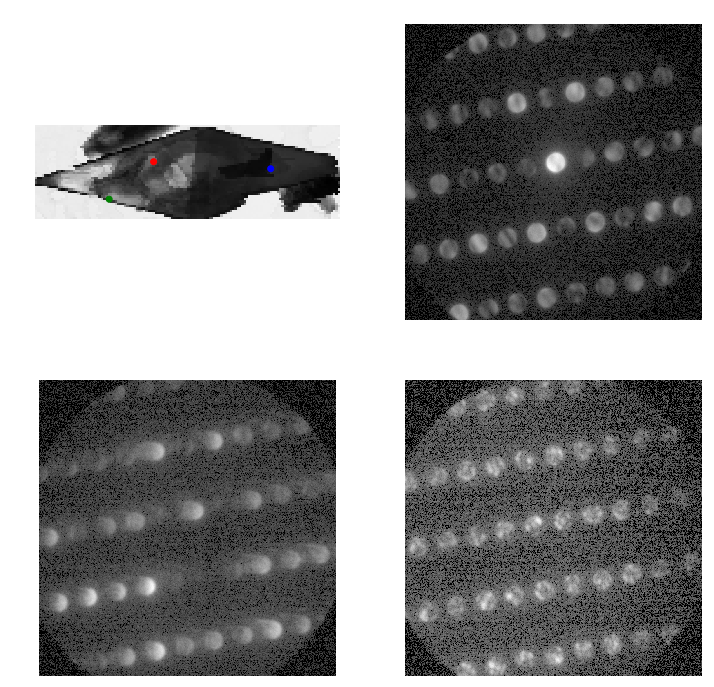

In [15]:
# Select and show 3 DPs

xs=(15,31,18)
ys=(50,31,100)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

In [20]:
# Select parameters
# Find Bragg disks in selected DPs

corrPower = 0.9
sigma_gaussianFilter = 2
edge_boundary = 20
maxNumPeaks = 70
minPeakSpacing = 60
minRelativeIntensity = 0.0005

coords = [('qx',float),('qy',float),('intensity',float)]
testBraggpeaks = []
for i in range(len(xs)):
    testBraggpeaks.append(PointList(coordinates=coords, parentDataCube=dc, name="test_Bragg_disks_xy={}_{}".format(xs[i],ys[i])))

t0=time()
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel.data2D))
for ind in range(len(xs)):
    Rx,Ry = xs[ind],ys[ind]
    print("Analyzing scan position {},{}".format(Rx,Ry))

    # Get diffraction pattern
    DP = dc.data4D[Rx,Ry,:,:]

    # Cross correlation     
    cc = py4DSTEM.process.utils.get_cross_correlation_fk(DP,probe_kernel_FT,corrPower)

    # Gaussian smoothing
    cc = np.maximum(cc,0)
    cc = gaussian_filter(cc, sigma_gaussianFilter)

    # Get maximal points
    max_points = py4DSTEM.process.utils.get_maximal_points(cc)

    # Remove points at edges
    max_points[:edge_boundary,:]=False
    max_points[-edge_boundary:,:]=False
    max_points[:,:edge_boundary]=False
    max_points[:,-edge_boundary:]=False    

    # Make point_list with structured array datatype ('rx','ry','qx','qy','intensity')
    point_list = testBraggpeaks[ind]

    max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
    point_intensities = cc[max_point_indices_x,max_point_indices_y]

    length = len(point_intensities)
    for i in range(length):
        new_point = (max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
        point_list.add_point(new_point)

    # Order point list, keep only up to maxNumPeaks
    numPeaks = min(maxNumPeaks,length)
    point_list.sort(coordinate='intensity',order='descending')
    deletePeaks = np.zeros(point_list.length, bool)
    deletePeaks[numPeaks:] = True
    point_list.remove_points(deletePeaks)         

    # Remove peaks that are too close together
    r2 = minPeakSpacing**2
    deletePeaks = np.zeros(numPeaks,dtype=bool)
    for i in range(numPeaks):
        if deletePeaks[i] == False:
            tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                      (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
            tooClose[:i+1] = False
            deletePeaks[tooClose] = True
    point_list.remove_points(deletePeaks)
    
    # Remove peaks below minRelativeIntensity threshold
    deletemask = point_list.data['intensity']/max(point_list.data['intensity']) < minRelativeIntensity
    point_list.remove_points(deletemask)
            
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Analyzing scan position 15,50
Analyzing scan position 31,31
Analyzing scan position 18,100
Finished in 0h 0m 0s


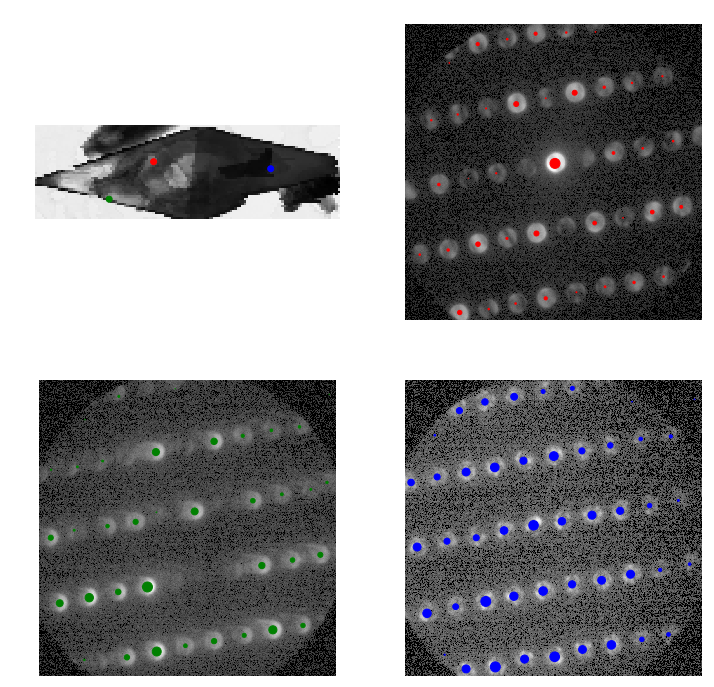

In [21]:
# Show results

power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = testBraggpeaks[0]
peaks1 = testBraggpeaks[1]
peaks2 = testBraggpeaks[2]

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Loop through DPs, finding all Bragg disks

In [ ]:
corrPower = 0.9
sigma_gaussianFilter = 2
edge_boundary = 20
maxNumPeaks = 70
minPeakSpacing = 60
minRelativeIntensity = 0.0005

coords = [('qx',float),('qy',float),('intensity',float)]
Braggpeak_pointlistarray = PointListArray(coordinates=coords, parentDataCube=dc, name="Bragg_disks")

t0=time()
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel.data2D))
for Rx in range(dc.R_Nx):
     for Ry in range(dc.R_Ny):
        print("Analyzing scan position {},{}".format(Rx,Ry))

        # Get diffraction pattern
        DP = dc.data4D[Rx,Ry,:,:]
        
        # Cross correlation     
        cc = py4DSTEM.process.utils.get_cross_correlation_fk(DP,probe_kernel_FT,corrPower)

        # Gaussian smoothing
        cc = np.maximum(cc,0)
        cc = gaussian_filter(cc, sigma_gaussianFilter)
        
        # Get maximal points
        max_points = py4DSTEM.process.utils.get_maximal_points(cc)
        
        # Remove points at edges
        max_points[:edge_boundary,:]=False
        max_points[-edge_boundary:,:]=False
        max_points[:,:edge_boundary]=False
        max_points[:,-edge_boundary:]=False    
       
        # Make point_list with structured array datatype ('rx','ry','qx','qy','intensity')
        point_list = Braggpeak_pointlistarray.get_pointlist(Rx,Ry)

        max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
        point_intensities = cc[max_point_indices_x,max_point_indices_y]

        length = len(point_intensities)
        for i in range(length):
            new_point = (max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
            point_list.add_point(new_point)
        
        # Order point list, keep only up to maxNumPeaks
        numPeaks = min(maxNumPeaks,length)
        point_list.sort(coordinate='intensity',order='descending')
        deletePeaks = np.zeros(point_list.length, bool)
        deletePeaks[numPeaks:] = True
        point_list.remove_points(deletePeaks)         

        # Remove peaks that are too close together
        r2 = minPeakSpacing**2
        deletePeaks = np.zeros(numPeaks,dtype=bool)
        for i in range(numPeaks):
            if deletePeaks[i] == False:
                tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                          (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
                tooClose[:i+1] = False
                deletePeaks[tooClose] = True
        point_list.remove_points(deletePeaks)
            
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

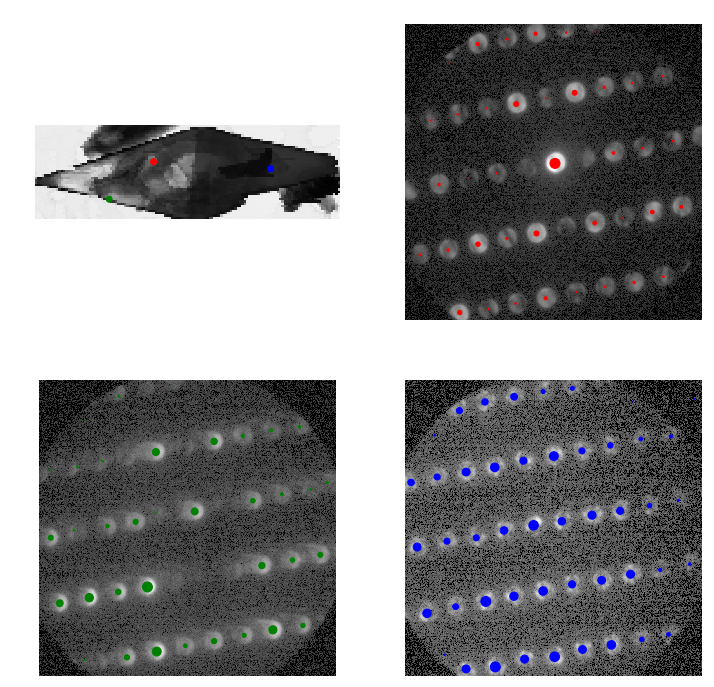

In [24]:
# Show results for a few DPs

xs=(15,31,18)
ys=(50,31,100)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Braggpeak_pointlistarray.get_pointlist(xs[0],ys[0])
peaks1 = Braggpeak_pointlistarray.get_pointlist(xs[1],ys[1])
peaks2 = Braggpeak_pointlistarray.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

In [25]:
# Copy Bragg peaks pointlistarray, to further threshold detected peaks

Braggpeak_pointlistarray_refined = Braggpeak_pointlistarray.copy()

In [26]:
# Remove points based on new peak spacing or minimum relative intensity thresholds

maxNumPeaks = 45
minPeakSpacing = 50
minRelativeIntensity = 0.001

for Rx in range(dc.R_Nx):
     for Ry in range(dc.R_Ny):

        point_list = Braggpeak_pointlistarray_refined.get_pointlist(Rx,Ry)

        # Order point list, keep only up to maxNumPeaks
        numPeaks = min(maxNumPeaks,point_list.length)
        point_list.sort(coordinate='intensity',order='descending')
        deletePeaks = np.zeros(point_list.length, bool)
        deletePeaks[numPeaks:] = True
        point_list.remove_points(deletePeaks) 
        
        # Remove peaks that are too close together
        point_list.sort(coordinate='intensity',order='descending')
        numPeaks = min(maxNumPeaks,point_list.length)
        r2 = minPeakSpacing**2
        deletePeaks = np.zeros(numPeaks,dtype=bool)
        for i in range(numPeaks):
            if deletePeaks[i] == False:
                tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                          (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
                tooClose[:i+1] = False
                deletePeaks[tooClose] = True
        point_list.remove_points(deletePeaks)
        
        # Remove peaks below minRelativeIntensity threshold
        deletemask = point_list.data['intensity']/max(point_list.data['intensity']) < minRelativeIntensity
        point_list.remove_points(deletemask)

IndexError: index 40 is out of bounds for axis 0 with size 40

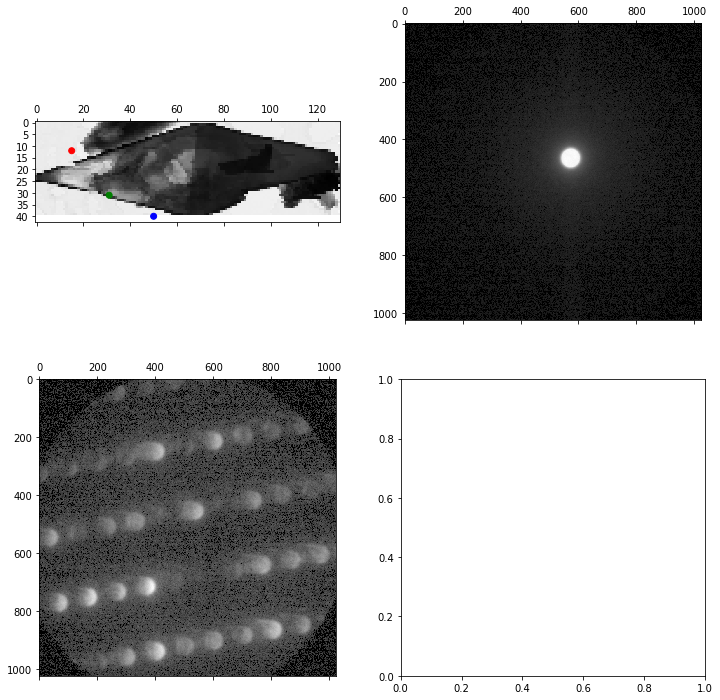

In [26]:
# Show newly thresholded results for a few DPs

xs=(12,31,40)
ys=(15,31,50)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Braggpeak_pointlistarray_refined.get_pointlist(xs[0],ys[0])
peaks1 = Braggpeak_pointlistarray_refined.get_pointlist(xs[1],ys[1])
peaks2 = Braggpeak_pointlistarray_refined.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Save Bragg disk list

In [9]:
# Save

savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5"
py4DSTEM.readwrite.save_dataobject(Braggpeak_pointlistarray_refined,savepath)

Creating file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5...
Writing metadata...
Done.


In [27]:
# Save

savepath = "/home/ben/Data/20190114_LiFePO4_100percentLithiated_secondbatch/processing/Bragg_disks.h5"
py4DSTEM.readwrite.save_dataobject(Braggpeak_pointlistarray_refined,savepath)

Creating file /home/ben/Data/20190114_LiFePO4_100percentLithiated_secondbatch/processing/Bragg_disks.h5...
Writing metadata...
Done.
